In [28]:
# Import Packages 
import torch 
from torch import nn

import pytesseract
import cv2

import argparse
import numpy as np
#import opencv_wrapper as cvw
from skimage.filters import threshold_local
import json

import random
from string import ascii_uppercase, digits, punctuation
import colorama
import regex

import matplotlib.pyplot as plt

get_info function is from https://gist.github.com/ttchengab/293fc3ca782b20cf9b05c33f13583338

In [29]:
"""
get_info() function reads the image using openCV and performs thresholding, dilation, noise removal, and
contouring to finally retrieve bounding boxes from the contour.
Below are some of the additional available functions from openCV for preprocessing:
Median filter: median filter blurs out noises by taking the medium from a set of pixels
cv2.medianBlur()
Dilation and erosion: dilation adds pixels to boundaries of pixels, erosion removes it
cv2.dilate()
cv2.erode()
cv2.opening() #This is an erosion followed by a dilation
"""

def get_info(path):
    font     = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontColor  = (255,0,0)
    lineType = 1

    #Threshold
    image = cv2.imread(path)

    height,width,channel = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    T = threshold_local(gray, 15, offset = 6, method = "gaussian") # generic, mean, median, gaussian
    thresh = (gray > T).astype("uint8") * 255
    thresh = ~thresh

    #Dilation
    kernel =np.ones((1,1), np.uint8)
    ero = cv2.erode(thresh, kernel, iterations= 1)
    img_dilation = cv2.dilate(ero, kernel, iterations=1)

    # Remove noise
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_dilation, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    final = np.zeros((labels.shape), np.uint8)
    for i in range(0, nlabels - 1):
        if sizes[i] >= 10:   #filter small dotted regions
            final[labels == i + 1] = 255

    #Find contours
    kern = np.ones((5,15), np.uint8)
    img_dilation = cv2.dilate(final, kern, iterations = 1)
    contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Map contours to bounding rectangles, using bounding_rect property
    rects = map(lambda c: cv2.boundingRect(c), contours)
    # Sort rects by top-left x (rect.x == rect.tl.x)
    sorted_rects = sorted(rects, key =lambda r: r[0])
    sorted_rects = sorted(sorted_rects, key =lambda r: r[1])

    etfo=''
    for rect in sorted_rects:
        x,y,w,h = rect
        if(w<20 or h<20):
            continue
        temp = image[y:y+h, x:x+w]
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        hi = pytesseract.image_to_data(temp, config=r'--psm 6')
        hi = hi.split()
        ind = 22
        while(True):
            if (ind>len(hi)):
                break
            hi_float = float(hi[ind])
            hi[ind]= int(hi_float)
            if(int(hi[ind])==-1):
                ind+=11
            else:
                etfo=etfo+hi[ind+1]
                etfo=etfo+" "
                x+=len(hi[ind+1])*20
                ind+=12
        etfo=etfo+'\n'
    return etfo

In [30]:
result = get_info('data/tj2024.png')

In [47]:
result

'\nere \nst land \nae \n\n4 \n\n$4 \nWest \nrTime \nny \n| \nRoad \nWarren \n36 4()] \n7 Cy \n48185 \nUnited \nStates \nland, \nMI \nWest \nJ \nee \n215-2400 \n134- \n. an a \n\nKKED \nSALE \nKCKKK \n€ \nReceipt \n001-240608- \n] \n1-075208 \n\n| \nStation: \nNew \nPOS \nStation \n7 \n\nDate: Cashier: \nDate: \n6/8/2024 \n] \n‘47 \nPM \nMarwan \nH \n& } \ny \n“i \n] \nJumper \n] \nA \n| \nDay \nPass \n$20. \n10 \nOpen \nJump \n2:00-2:39 \n6/8/2024 \n\non \n\n] \nJumper \n| \n] \nA \nDay \nPass \n$20, \n710 \n3 \nOpen \nJump \n2:00-2:30 \n6/8/2024 \n| \nr * \non \nrs \n| \nJutiper \n] \n] \nA \nDay \nPass \n$20, \n70 \n\nOpen \nJump \n2:00-2:30 \n6/8/2024 \nr * \non \npw \n| \nJumper \n] \n] \nA \nDay \nPass \n$20. \n10 \n3 \nOpen \nJump \nit ¥ A # \n6/8/2024 \n2:00-7:30 \non \n1 \nSocks \n$2.93 \nSut) \n| \nTota \nS85. \nwit} \nats) \nVes \nTax: \nSa \n$0. \nTee ee \n$85 .9) $85 91 \n| \n$85 \nTota \n(rder \nTendered: \nAmount \nrv \n\nGratuities \nSuggested \n04) \n($90 \n14 \n$4. \n(

In [31]:
#0. Load the image and show some basic information
img = cv2.imread('data/tj2024.png')
height,width,channel = img.shape
print(height,width,channel)

3200 1282 3


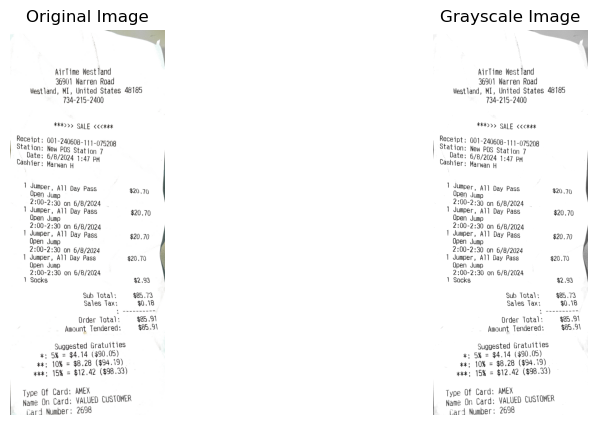

In [32]:
#1. Convert the image to grayscale
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show the original image and the greyed image
fig, axs = plt.subplots(1,2, figsize=(10,5))
# Display the original image in the first subplot
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Display the grayscale image in the second subplot
axs[1].imshow(grey_img, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[1].axis('off')  # Hide axes ticks

plt.show()

In [33]:
# 2. applies a local threshold to an image, meaning that for each pixel, its threshold value is determined based on the pixel
block_size = 35 # size of the local region to calculate the threshold
T = threshold_local(grey_img, block_size, offset = 6, method = "gaussian") # generic, mean, median, gaussian

In [34]:
print(f"Comparison RGB: {img[1,1]}, grayscale {grey_img[1,1]}, threshold: {T[1,1]}")

Comparison RGB: [255 255 255], grayscale 255, threshold: 248.9999999480629


In [35]:
# For all the values in the image, if the value is greater than the threshold, set it to 255, else set it to 0
thresh_img = (grey_img > T).astype("uint8") * 255
thresh_img = ~thresh_img # Reverse the image to get the text in white and background in black


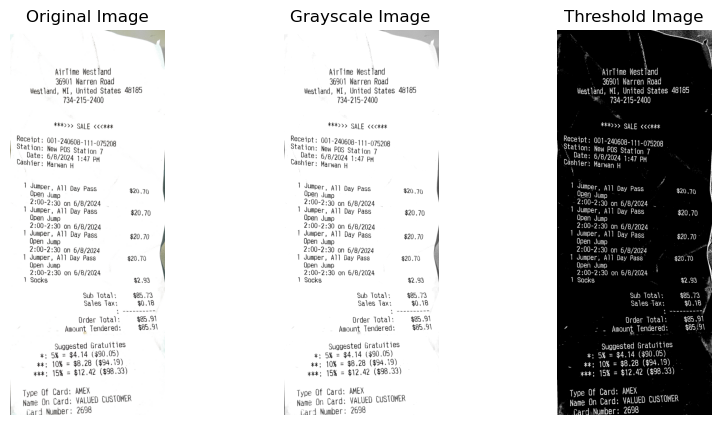

In [36]:
# Show the original image, the greyed image and the threshold image
fig, axs = plt.subplots(1,3, figsize=(10,5))
# Display the original image in the first subplot
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Display the grayscale image in the second subplot
axs[1].imshow(grey_img, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[1].axis('off')  # Hide axes ticks

# Display the Threshold image in the third subplot
axs[2].imshow(thresh_img, cmap='gray')
axs[2].set_title('Threshold Image')
axs[2].axis('off')  # Hide axes ticks

plt.show()

Next step involves reducing the brightness of pixels based on the characteristics of the kernel. This operation is primarily used for reducing noise, separating individual elements, and shrinking objects in a binary or grayscale image.

In [37]:
#3. Dilation
kernel =np.ones((1,1), np.uint8)
erode_img = cv2.erode(thresh_img, kernel, iterations= 1)
print(f"Difference between erode and threshold: {np.sum(np.sum(erode_img - thresh_img))}")
#img_dilation = cv2.dilate(erode_img, kernel, iterations=1)

Difference between erode and threshold: 0


In [38]:
dilation_img = cv2.dilate(erode_img, kernel, iterations=1)
print(f"Difference between dilation and threshold: {np.sum(np.sum(erode_img - dilation_img))}")


Difference between dilation and threshold: 0


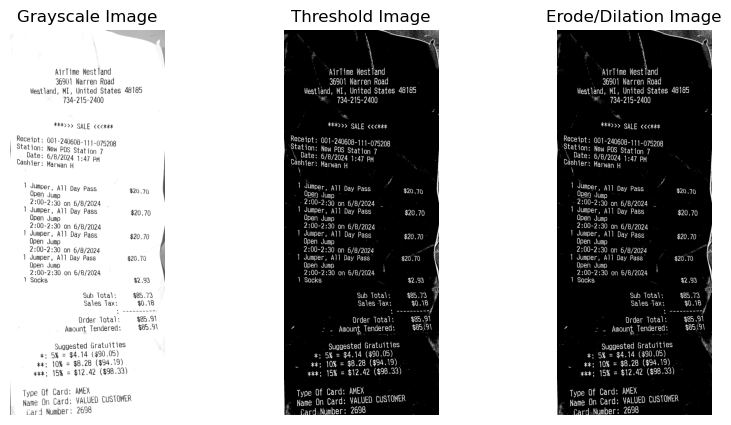

In [39]:
# Show the greyed image, the threshold image and the erode image
fig, axs = plt.subplots(1,3, figsize=(10,5))

# Display the grayscale image in the first subplot
axs[0].imshow(grey_img, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[0].axis('off')  # Hide axes ticks

# Display the Threshold image in the second subplot
axs[1].imshow(thresh_img, cmap='gray')
axs[1].set_title('Threshold Image')
axs[1].axis('off')  # Hide axes ticks

# Display the Eroded/Dilation image in the third subplot
axs[2].imshow(dilation_img, cmap='gray')
axs[2].set_title('Erode/Dilation Image')
axs[2].axis('off')  # Hide axes ticks


plt.show()

Eroding and Dilation step didn't have any affect visually and numerically so I will consider skipping the step for performances reasons.

Step 4: Try removing noise using connectedComponentsWithStats.
*  Removing noise using connectedComponentsWithStats function in OpenCV. It is used to detect connected components in binary images, with statistics and centroids for each labeled component. Two pixels are considered part of the same connected component if they are neighbors and have the same value. The connectivity can be either 4-connected or 8-connected.  For each detected component, it calculates the centroid and statistics, which typically include the bounding box dimensions and the area

In [40]:
 #4. Remove noise
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilation_img, None, None, None, 8, cv2.CV_32S)
print(f"Number of labels: {nlabels}: Size of labels: {labels.shape}, stats: {stats.shape}, and centroids: {centroids.shape}")

Number of labels: 6759: Size of labels: (3200, 1282), stats: (6759, 5), and centroids: (6759, 2)


In [41]:
# first four columns of stats are x, y, width, height and the last column is the area of the connected component
stats[2]

array([777,   0,   1,   1,   1], dtype=int32)

In [42]:
# 4b: filter out the small dotted regions
minimum_area = 10;
sizes = stats[1:, -1] #get CC_STAT_AREA component
final = np.zeros((labels.shape), np.uint8)
for i in range(0, nlabels - 1):
    if sizes[i] >= minimum_area:   #filter out small dotted regions
        final[labels == i + 1] = 255

In [43]:
 # 4c: Find contours
kern = np.ones((5,15), np.uint8)
connected_img = cv2.dilate(final, kern, iterations = 1)
contours_img, hierarchy = cv2.findContours(connected_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Map contours to bounding rectangles, using boundingRect property
rects = map(lambda c: cv2.boundingRect(c), contours_img)

In [44]:
# Sort rects by top-left x (rect.x == rect.tl.x)
sorted_rects = sorted(rects, key =lambda r: r[0])
sorted_rects = sorted(sorted_rects, key =lambda r: r[1])

etfo=''
for rect in sorted_rects:
    x,y,w,h = rect
    if(w<20 or h<20):
        continue
    temp_img = img[y:y+h, x:x+w]
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    # Adds bounding boxes to the image
    boxed_img = pytesseract.image_to_data(temp_img, config=r'--psm 6')
    boxed_img = boxed_img.split()
    box_length = 22
    while(True):
        if (box_length>len(boxed_img)):
             break
        bi_float = float(boxed_img[box_length])
        boxed_img[box_length]= int(bi_float)
        if(int(boxed_img[box_length])==-1):
            box_length+=11
        else:
            etfo=etfo+boxed_img[box_length+1]
            etfo=etfo+" "
            x+=len(boxed_img[box_length+1])*20
            box_length+=12
    etfo=etfo+'\n'

In [45]:
len(etfo)

999

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (571,) + inhomogeneous part.

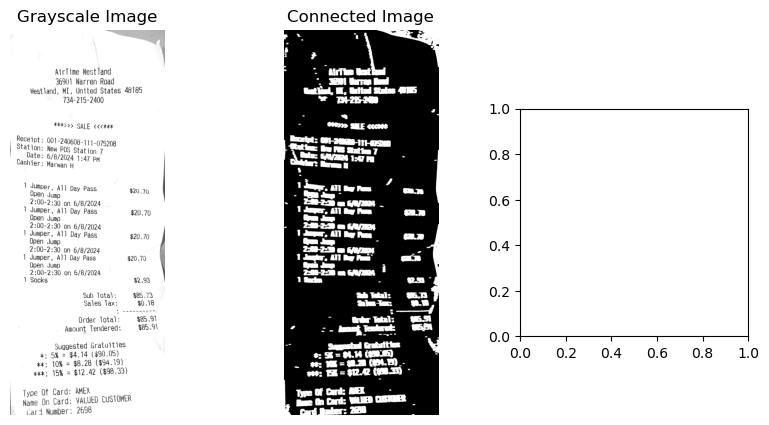

In [46]:
# Show the greyed image, the connected image and the contour image
fig, axs = plt.subplots(1,3, figsize=(10,5))

# Display the grayscale image in the first subplot
axs[0].imshow(grey_img, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[0].axis('off')  # Hide axes ticks

# Display the Threshold image in the second subplot
axs[1].imshow(connected_img, cmap='gray')
axs[1].set_title('Connected Image')
axs[1].axis('off')  # Hide axes ticks

# Display the Eroded/Dilation image in the third subplot
axs[2].imshow(contours_img)
axs[2].set_title('Contoured Image')
axs[2].axis('off')  # Hide axes ticks


plt.show()